## Analyze data and Prepare feature

### import necessary library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib

### analyze data relationships

Saved figure in ../results/figures/correlation_matrix.png


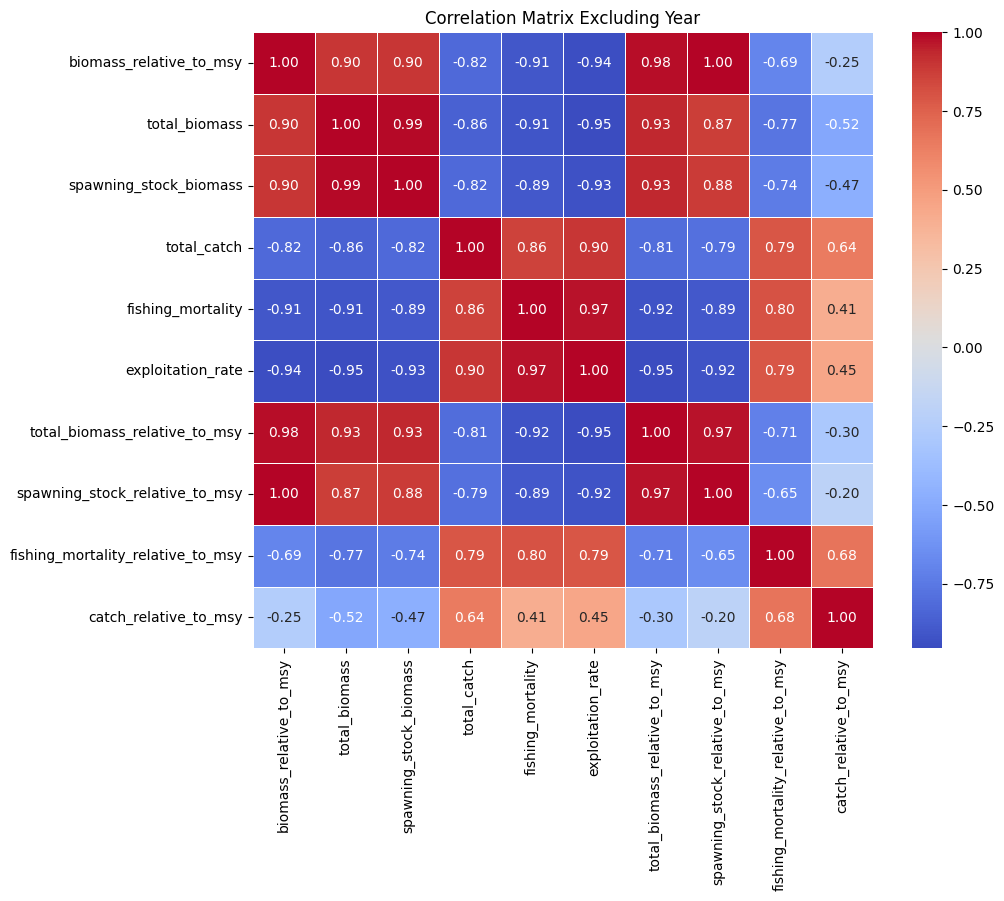

In [2]:
# handle error solving
try:
    df = pd.read_csv('../data/processed/clean3.csv')
except Exception as e:
    print("Oops! Something went wrong. ensure you have run file: preprocess.ipynb")
    raise

# Drop 'Year' column
df_without_year = df.drop(columns=['Year'])

# Calculate the correlation matrix
correlation_matrix = df_without_year.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Excluding Year')
# Save the plot to a file
file_path = '../results/figures/correlation_matrix.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()



## Train model

### split train and test data

In [3]:
df = pd.read_csv('../data/processed/train.csv')

df['total_biomass'] = df['total_biomass']
threshold = int(len(df)*0.8)
train = df.iloc[:threshold]
test = df.iloc[threshold:]

train.to_csv('../data/processed/train.csv',index = False)
test.to_csv('../data/processed/test.csv',index = False)

### compare interested model

In [4]:
train_path = '../data/processed/train.csv'
test_path = '../data/processed/test.csv'

Epoch 1/100


c:\Users\adila\OneDrive\Desktop\final_maz\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1654 - val_loss: 9.4889e-05
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1560 - val_loss: 6.9479e-05
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1508 - val_loss: 1.0912e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1453 - val_loss: 2.2134e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1411 - val_loss: 4.1694e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1342 - val_loss: 7.0799e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1280 - val_loss: 0.0011
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1230 - val_loss: 0.0016
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1134 - val_loss: 0.0023
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1056 - val_loss: 0.0031
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1044 - val_loss: 0.0042
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.091

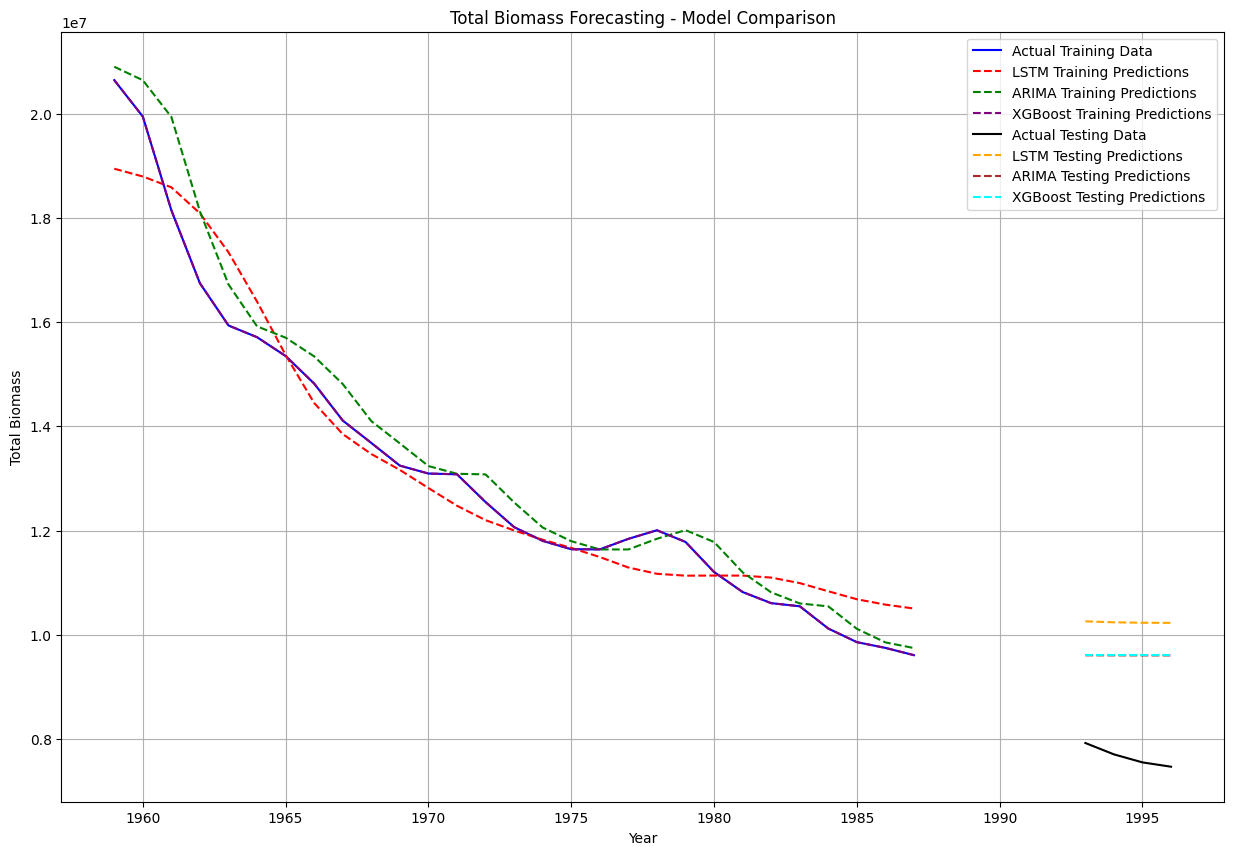

LSTM Training Evaluation Metrics:
  Mean Squared Error (MSE): 487466506552.3106
  Root Mean Squared Error (RMSE): 698188.0166
  Mean Absolute Error (MAE): 543750.2414
  R-squared (R2): 0.9417

LSTM Testing Evaluation Metrics:
  Mean Squared Error (MSE): 6667161445823.2510
  Root Mean Squared Error (RMSE): 2582084.7093
  Mean Absolute Error (MAE): 2577003.7500
  R-squared (R2): -221.3745

ARIMA Training Evaluation Metrics:
  Mean Squared Error (MSE): 313776061467.5672
  Root Mean Squared Error (RMSE): 560157.1757
  Mean Absolute Error (MAE): 408319.3841
  R-squared (R2): 0.9625

ARIMA Testing Evaluation Metrics:
  Mean Squared Error (MSE): 3803575356348.1025
  Root Mean Squared Error (RMSE): 1950275.7129
  Mean Absolute Error (MAE): 1942628.6414
  R-squared (R2): -125.8633

XGBoost Training Evaluation Metrics:
  Mean Squared Error (MSE): 79.7241
  Root Mean Squared Error (RMSE): 8.9288
  Mean Absolute Error (MAE): 7.3103
  R-squared (R2): 1.0000

XGBoost Testing Evaluation Metrics:
  Me

In [5]:
def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def create_features(data, target, lookback):
    """Create features for XGBoost"""
    df = pd.DataFrame(data)
    for i in range(1, lookback + 1):
        df[f'lag_{i}'] = df[target].shift(i)
    df = df.dropna()
    return df

# Load and preprocess data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Extract total_biomass and normalize data for LSTM
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train['total_biomass'].values.reshape(-1, 1))
test_data = scaler.transform(test['total_biomass'].values.reshape(-1, 1))

# Parameters
sequence_length = 5
epochs = 100
batch_size = 32
lookback = sequence_length  # Make sure lookback equals sequence_length

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data for LSTM [samples, time steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create and train LSTM model
lstm_model = Sequential([ 
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, 
               validation_split=0.1, verbose=1)

# LSTM predictions
lstm_train_predict = scaler.inverse_transform(lstm_model.predict(X_train_lstm))
lstm_test_predict = scaler.inverse_transform(lstm_model.predict(X_test_lstm))
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# Prepare data for ARIMA
arima_train = train_df['total_biomass'].values
arima_test = test_df['total_biomass'].values

# Fit ARIMA model
arima_model = ARIMA(arima_train, order=(1,1,1))
arima_fit = arima_model.fit()

# Make ARIMA predictions
arima_train_predict = arima_fit.predict(start=sequence_length, 
                                      end=len(arima_train)-1)
arima_test_predict = arima_fit.forecast(steps=len(arima_test)-sequence_length)

# Prepare data for XGBoost
train_features = create_features(train_df['total_biomass'], 'total_biomass', lookback)
test_features = create_features(test_df['total_biomass'], 'total_biomass', lookback)

X_train_xgb = train_features.drop('total_biomass', axis=1)
y_train_xgb = train_features['total_biomass']
X_test_xgb = test_features.drop('total_biomass', axis=1)
y_test_xgb = test_features['total_biomass']

# Create and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)  

xgb_model.fit(X_train_xgb, y_train_xgb)

# XGBoost predictions
xgb_train_predict = xgb_model.predict(X_train_xgb)
xgb_test_predict = xgb_model.predict(X_test_xgb)

# Prepare time axes with correct dimensions
train_years = train_df['Year'][sequence_length:].values
test_years = test_df['Year'][sequence_length:].values

# Plot results with only Train and Test Data (Discontinuous graph)
plt.figure(figsize=(15, 10))

# Training data
plt.plot(train_years, y_train_inv, label='Actual Training Data', color='blue')
plt.plot(train_years, lstm_train_predict, 
         label='LSTM Training Predictions', color='red', linestyle='--')
plt.plot(train_years, arima_train_predict, 
         label='ARIMA Training Predictions', color='green', linestyle='--')
plt.plot(train_years, xgb_train_predict, 
         label='XGBoost Training Predictions', color='purple', linestyle='--')

# Testing data
plt.plot(test_years, y_test_inv, label='Actual Testing Data', color='black')
plt.plot(test_years, lstm_test_predict, 
         label='LSTM Testing Predictions', color='orange', linestyle='--')
plt.plot(test_years, arima_test_predict, 
         label='ARIMA Testing Predictions', color='brown', linestyle='--')
plt.plot(test_years, xgb_test_predict, 
         label='XGBoost Testing Predictions', color='cyan', linestyle='--')

plt.title('Total Biomass Forecasting - Model Comparison')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.grid(True)
file_path = '../results/figures/compare_model.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()

# Print model evaluation metrics for all models
def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R2): {r2:.4f}\n")

print_metrics(y_train_inv, lstm_train_predict, "LSTM Training")
print_metrics(y_test_inv, lstm_test_predict, "LSTM Testing")
print_metrics(y_train_inv, arima_train_predict, "ARIMA Training")
print_metrics(y_test_inv, arima_test_predict, "ARIMA Testing")
print_metrics(y_train_xgb, xgb_train_predict, "XGBoost Training")
print_metrics(y_test_xgb, xgb_test_predict, "XGBoost Testing")

### test ARIMA model

Train RMSE: 4162796.2497656336
Test RMSE: 1099636.4357510337
Test R^2: -5.285404827626403
Saved figure in ../results/figures/test_ARIMA.png


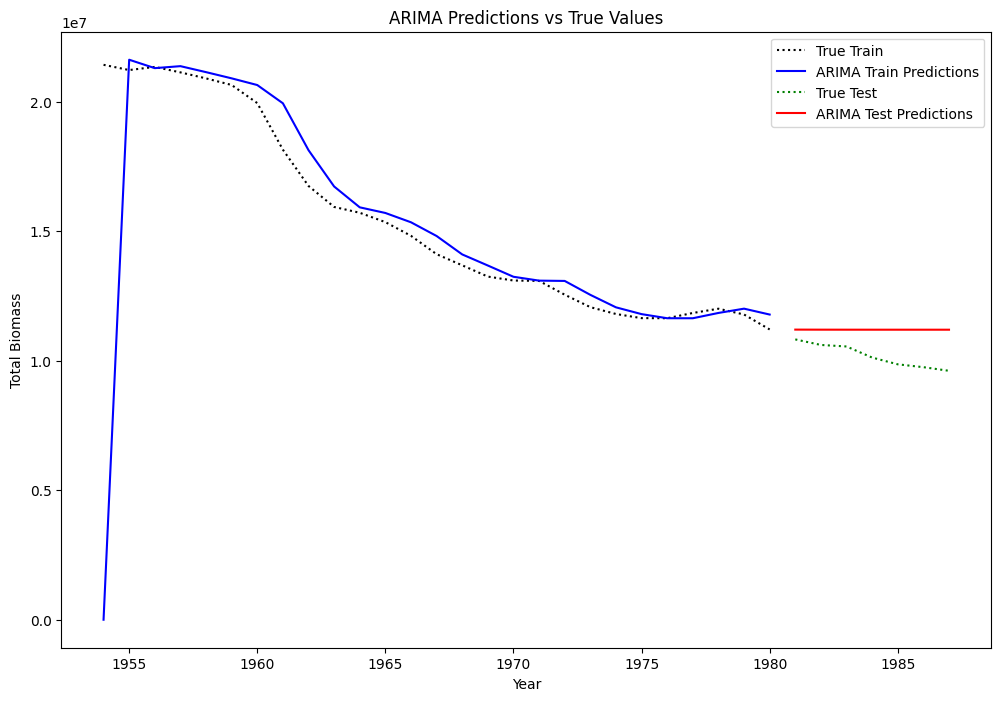

In [6]:
# Load your data
data = pd.read_csv(train_path)
data = data.sort_values('Year')  # Ensure data is sorted by 'Year'
data.set_index('Year', inplace=True)  # Set 'Year' as the index

# Select the target variable for ARIMA modeling
target_column = 'total_biomass'

# Split into train and test sets
train_size = int(len(data) * 0.8)
train_df = data.iloc[:train_size]
test_df = data.iloc[train_size:]

# Prepare data for ARIMA
arima_train = train_df[target_column].values
arima_test = test_df[target_column].values

# Fit ARIMA model
arima_model = ARIMA(arima_train, order=(1, 1, 1))  # Adjust (p, d, q) as needed
arima_fit = arima_model.fit()

# Make ARIMA predictions
# Predict within the training set
arima_train_predict = arima_fit.predict(start=0, end=len(arima_train) - 1)

# Forecast for the test set
arima_test_predict = arima_fit.forecast(steps=len(arima_test))

# Evaluate predictions
train_rmse = np.sqrt(mean_squared_error(arima_train, arima_train_predict))
test_rmse = np.sqrt(mean_squared_error(arima_test, arima_test_predict))
test_r2 = r2_score(arima_test, arima_test_predict)

# Print evaluation metrics

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R^2: {test_r2}")

# Plot the results
plt.figure(figsize=(12, 8))

# Training set
plt.plot(train_df.index, arima_train, label='True Train', color='black', linestyle='dotted')
plt.plot(train_df.index, arima_train_predict, label='ARIMA Train Predictions', color='blue')

# Test set
plt.plot(test_df.index, arima_test, label='True Test', color='green', linestyle='dotted')
plt.plot(test_df.index, arima_test_predict, label='ARIMA Test Predictions', color='red')

plt.title('ARIMA Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
file_path = '../results/figures/test_ARIMA.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()

### test XGBoost model

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Saved figure in ../results/figures/test_XGBoost.png


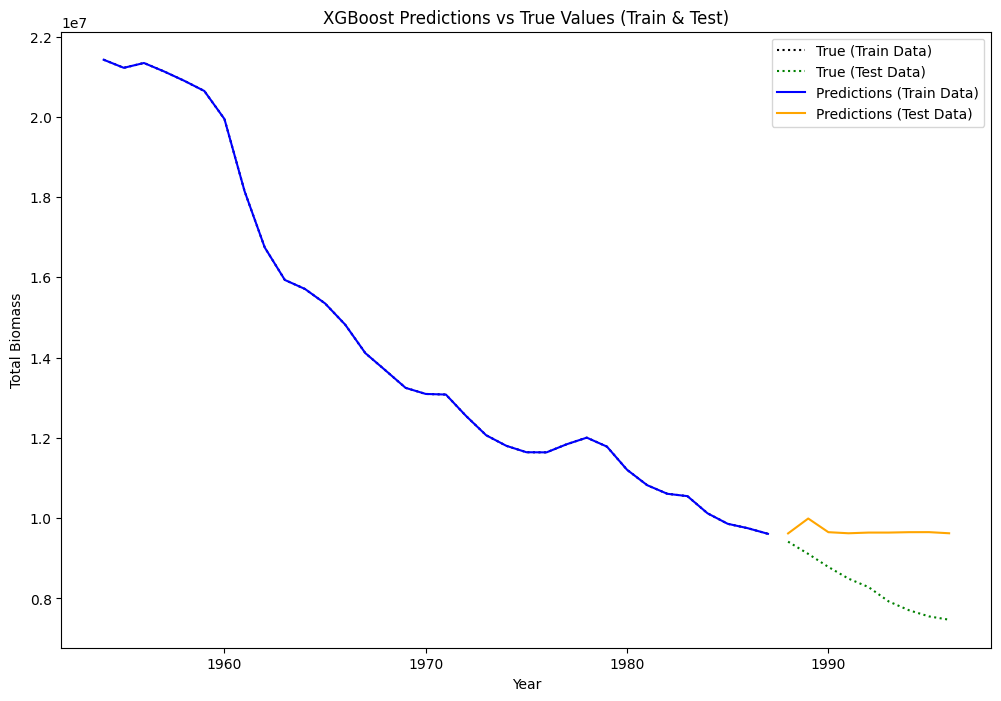

Train RMSE: 285.3311285877804
Train R^2: 1.0
Test RMSE: 1508054.0186115496
Test R^2: -4.2327775955200195


In [7]:
data = pd.read_csv(train_path)
data = data.sort_values('Year')
X = data.drop(['Year', 'total_biomass'], axis=1)
y = data['total_biomass']

# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model and hyperparameters
model = XGBRegressor(objective='reg:squarederror', random_state=42)
params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10]
}

# Train the model using GridSearchCV
grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# Predict and evaluate on training data
y_pred = best_model.predict(X_scaled)

# Load and prepare the test data
test_data = pd.read_csv(test_path)
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Combine train and test data for plotting
train_years = data['Year']
test_years = test_data['Year']

train_true = y
test_true = y_test

train_pred = y_pred
test_pred = y_test_pred

# Plot both train and test data on the same graph
plt.figure(figsize=(12, 8))

# Plot true values for train and test data
plt.plot(train_years, train_true, label='True (Train Data)', color='black', linestyle='dotted')
plt.plot(test_years, test_true, label='True (Test Data)', color='green', linestyle='dotted')

# Plot predictions for train and test data
plt.plot(train_years, train_pred, label='Predictions (Train Data)', color='blue')
plt.plot(test_years, test_pred, label='Predictions (Test Data)', color='orange')

# Add title and labels
plt.title('XGBoost Predictions vs True Values (Train & Test)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')

# Add legend
plt.legend()
file_path = '../results/figures/test_XGBoost.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
# Show plot
plt.show()

# Print evaluation metrics for train data
print(f"Train RMSE: {np.sqrt(mean_squared_error(train_true, train_pred))}")
print(f"Train R^2: {r2_score(train_true, train_pred)}")

# Print evaluation metrics for test data
print(f"Test RMSE: {np.sqrt(mean_squared_error(test_true, test_pred))}")
print(f"Test R^2: {r2_score(test_true, test_pred)}")


## train and test model (XGBoost) after resampling data

In [8]:
# split train and test
df = pd.read_csv('../data/processed/resampling_data.csv')
df = df.drop(columns=['Normalized'])
df['total_biomass'] = df['total_biomass']
threshold = int(len(df)*0.8)
train = df.iloc[:threshold]
test = df.iloc[threshold:]

train_path = '../data/processed/re_train.csv'
test_path = '../data/processed/re_test.csv'

train.to_csv(train_path,index=False)
test.to_csv(test_path,index=False)

### &#8226; unnormalize

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


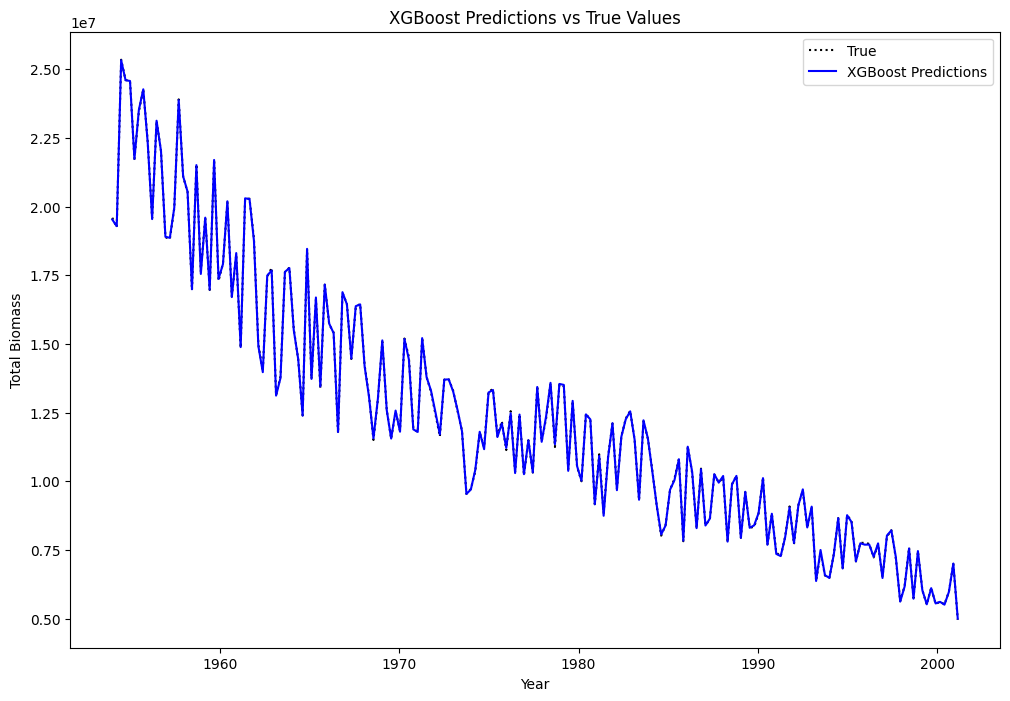

RMSE: 37512.36094723639
R^2: 0.9999366943665174
Model saved successfully!


In [9]:
# train

# Load and prepare the data
data = pd.read_csv(train_path)
data = data.sort_values('Year')
X = data.drop(['Year', 'total_biomass'], axis=1)
y = data['total_biomass']

# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model and hyperparameters
model = XGBRegressor(objective='reg:squarederror', random_state=42)
params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01,0.05, 0.1],
    "max_depth": [3, 5, 7]
}

# Train the model using GridSearchCV
grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")


# Predict and evaluate
y_pred = best_model.predict(X_scaled)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(data['Year'], y, label='True', color='black', linestyle='dotted')
plt.plot(data['Year'], y_pred, label='XGBoost Predictions', color='blue')
plt.title('XGBoost Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred))}")
print(f"R^2: {r2_score(y, y_pred)}")

# Save the model
joblib.dump(best_model, '../results/output/best_raw_xgb_model.pkl')
print("Model saved successfully!")

Saved figure in ../results/output/unnormalize_XGBoost_test.png


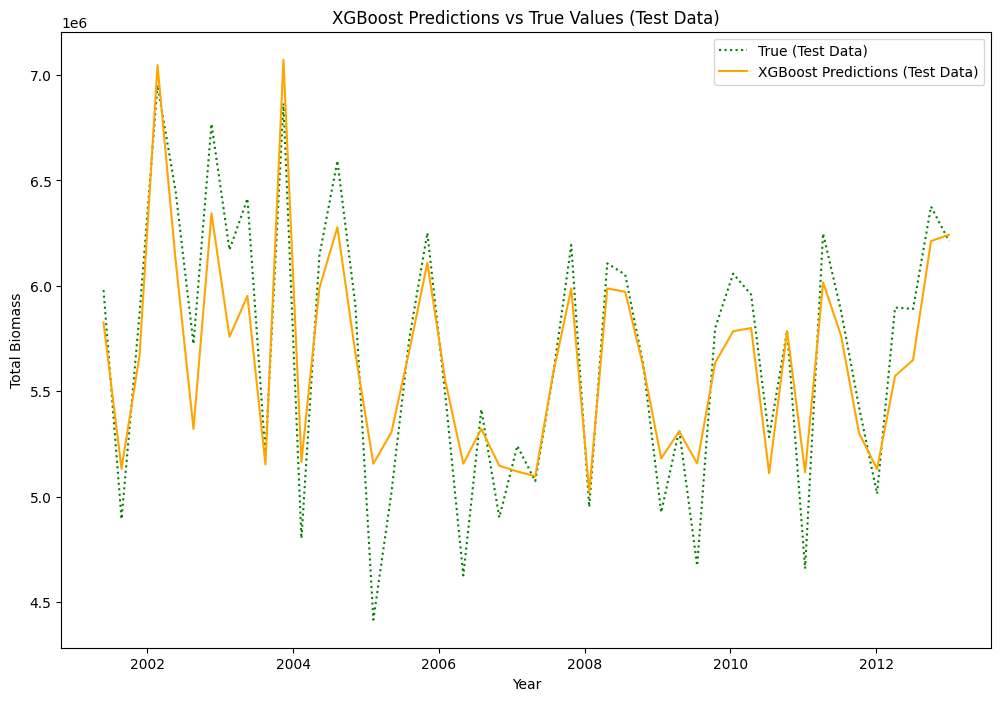

Test RMSE: 264370.8587782183
Test R^2: 0.8252331207895703


In [10]:
# test

# Load and prepare the test data
test_data = pd.read_csv(test_path)
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
file_path = '../results/output/unnormalize_XGBoost_test.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()

# Print evaluation metrics for test data

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")

### &#8226; normalize (divide by 10^6)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


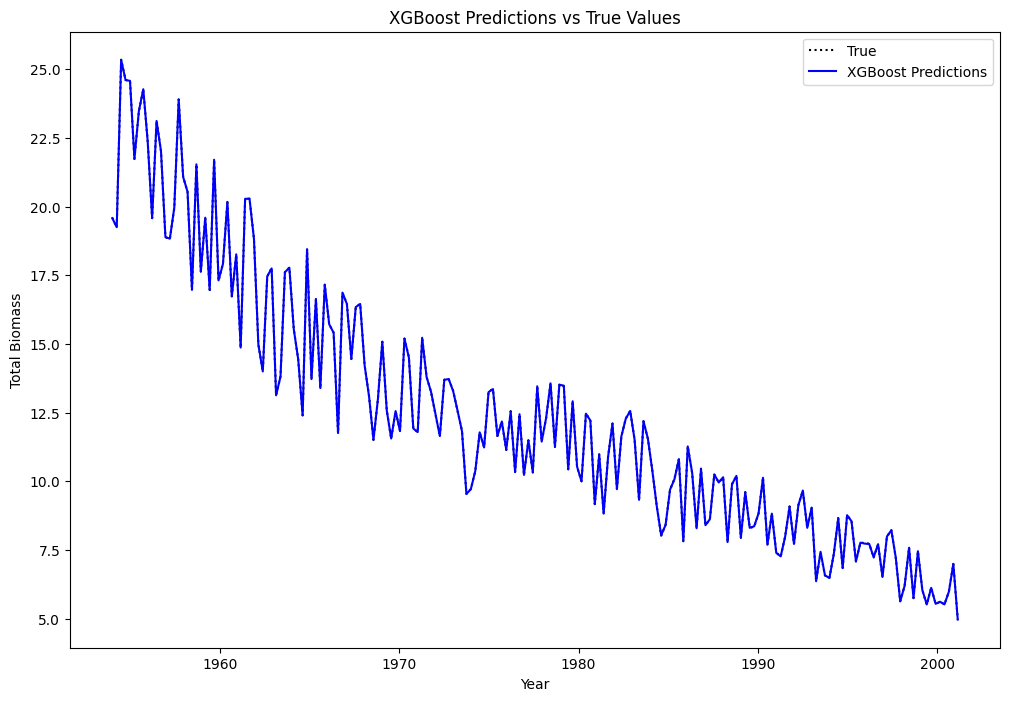

RMSE: 0.009449489068772
R^2: 0.999995982922451


In [11]:
# train

# Load and prepare the data
data = pd.read_csv(train_path)
data = data.sort_values('Year')
X = data.drop(['Year', 'total_biomass'], axis=1)
y = data['total_biomass'] / 1e6

# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model and hyperparameters
model = XGBRegressor(objective='reg:squarederror', random_state=42)
params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01,0.05, 0.1],
    "max_depth": [3, 5, 7]
}

# Train the model using GridSearchCV
grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# Predict and evaluate
y_pred = best_model.predict(X_scaled)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(data['Year'], y, label='True', color='black', linestyle='dotted')
plt.plot(data['Year'], y_pred, label='XGBoost Predictions', color='blue')
plt.title('XGBoost Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred))}")
print(f"R^2: {r2_score(y, y_pred)}")


Saved figure in ../results/output/normalize_XGBoost_test.png


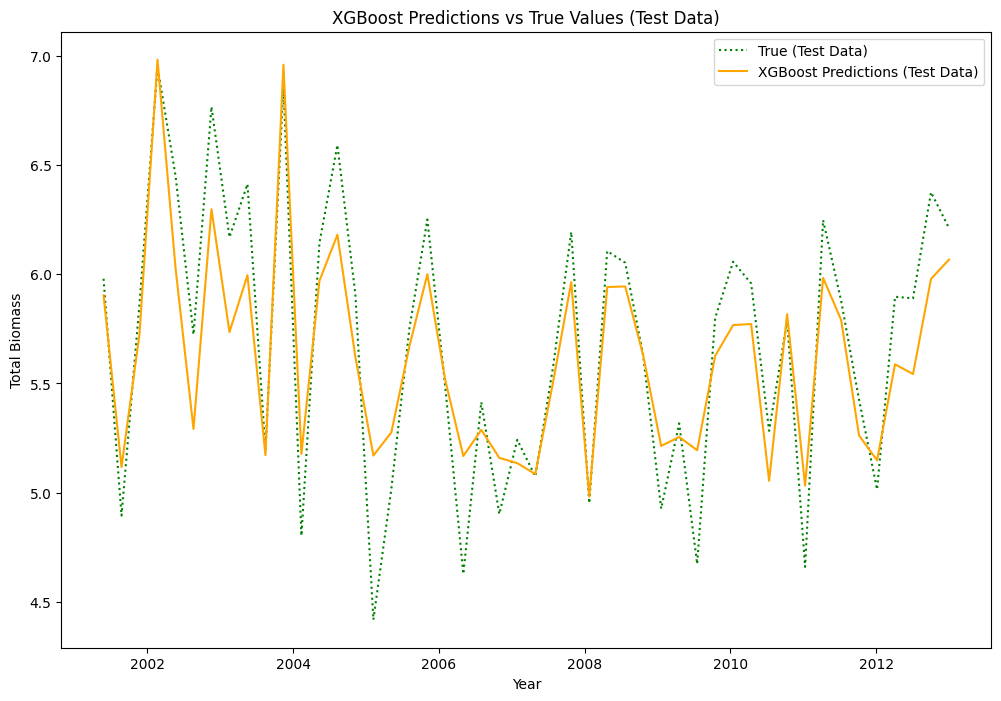

Test RMSE: 0.28357304790891624
Test R^2: 0.7989232441185168


In [12]:
# test

# Load and prepare the test data
test_data = pd.read_csv(test_path)
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass'] / 1e6

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
file_path = '../results/output/normalize_XGBoost_test.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()

# Print evaluation metrics for test data

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")

### test prediction raw data

Saved figure in ../results/output/XGBoost_test_raw_data.png


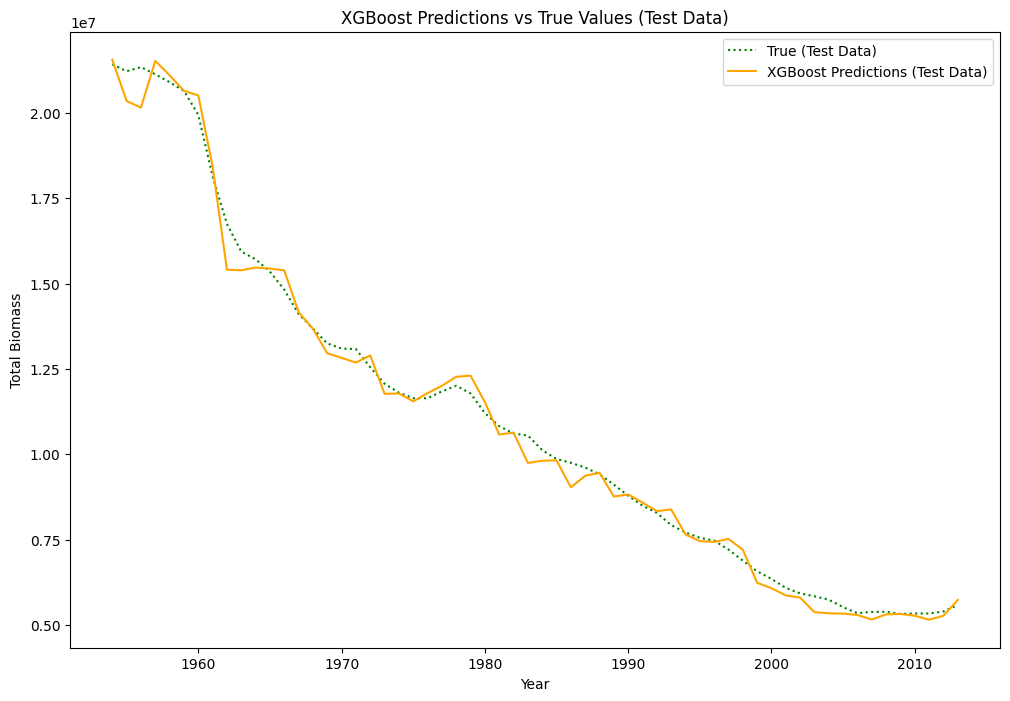

Test RMSE: 387706.53156484436
Test R^2: 0.9936937093734741


In [13]:
# test raw

# Load and prepare the test data
test_data = pd.read_csv('../data/processed/clean3.csv')

# test_data = test_data.iloc[int(len(test_data)*0.6):]

test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']

best_xgb_model = joblib.load('../results/output/best_raw_xgb_model.pkl')

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_xgb_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
file_path = '../results/output/XGBoost_test_raw_data.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f'Saved figure in {file_path}')
plt.show()

# Print evaluation metrics for test data

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")